In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, mean_squared_error,  precision_score, recall_score, f1_score
import torch
import torch.nn as nn
import pandas as pd
from tqdm import tqdm
import time
torch.manual_seed(42)
np.random.seed(42)

# First Feature Map

In [2]:

# Configuration
n_qubits = 2
input_dim = 2
res = 30  # resolution of x1, x2 grid
X_vals = np.linspace(0, 2 * np.pi, res)
X1, X2 = np.meshgrid(X_vals, X_vals)
inputs = np.stack([X1.ravel(), X2.ravel()], axis=1)


In [3]:

# Encoding
# 1. Current encoding (Rx, Rx, RY(x0*x1), RY(x1*x0))
def encoding_original(x):
    qml.RX(x[0], wires=0)
    qml.RX(x[1], wires=1)
    qml.RY(x[0]*x[1], wires=0)
    qml.RY(x[1]*x[0], wires=1)

# 2. Rx(x0), Rx(x1) only
def encoding_rx_only(x):
    qml.RX(x[0], wires=0)
    qml.RX(x[1], wires=1)

# 3. Chebyshev (sparse): T_1(x), T_2(x)
def encoding_chebyshev_sparse(x):
    qml.RX(np.cos(x[0]), wires=0)
    qml.RX(np.cos(x[1]), wires=0)
    qml.RX(np.cos(x[0]), wires=1)
    qml.RX(np.cos(x[1]), wires=1)

# 4. Chebyshev (tower): T_1, T_2, T_3 on both
def encoding_chebyshev_tower(x):
    qml.RX(np.cos(x[0]), wires=0)
    qml.RX(np.cos(2*x[0]), wires=0)
    qml.RX(np.cos(3*x[0]), wires=0)
    qml.RX(np.cos(x[1]), wires=1)
    qml.RX(np.cos(2*x[1]), wires=1)
    qml.RX(np.cos(3*x[1]), wires=1)

# 5. Fourier (up to sin(3x), cos(3x))
def encoding_fourier(x):
    for i in range(1, 4):
        qml.RX(np.sin(i * x[0]), wires=0)
        qml.RX(np.cos(i * x[0]), wires=0)
        qml.RX(np.sin(i * x[1]), wires=1)
        qml.RX(np.cos(i * x[1]), wires=1)

    
# Variational block
def variational_block(weights):
    for i in range(n_qubits):
        qml.RZ(weights[i, 0], wires=i)
        qml.RY(weights[i, 1], wires=i)
        qml.RZ(weights[i, 2], wires=i)
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 0])

# Create circuit
def create_qnode(depth, weights, dev, num_reupload, encoding_func):
    @qml.qnode(dev)
    def circuit(x):
        count = 0
        for d in range(depth):
            if count < num_reupload:
                encoding_func(x)
                count += 1
            variational_block(weights[d])
        return qml.expval(qml.PauliZ(0))
    return circuit



In [4]:

# Label from circuit
def generate_labels(circuit, X):
    return np.array([1 if circuit(x) > 0 else 0 for x in X])


In [5]:
def get_torch_model(depth, dev, num_reupload, encoding_func):
    weight_shapes = {"weights": (depth, n_qubits, 3)}

    @qml.qnode(dev, interface="torch")
    def circuit(inputs, weights):
        count = 0
        for d in range(depth):
            if count < num_reupload:
                encoding_func(inputs)
                count += 1
            for i in range(n_qubits):
                qml.RZ(weights[d, i, 0], wires=i)
                qml.RY(weights[d, i, 1], wires=i)
                qml.RZ(weights[d, i, 2], wires=i)
            qml.CNOT(wires=[0, 1])
            qml.CNOT(wires=[1, 0])
        return qml.expval(qml.PauliZ(0))

    return qml.qnn.TorchLayer(circuit, weight_shapes)


In [6]:

# Training loop
def train_model(model, X_train, y_train, epochs=100, lr=0.1):
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.BCEWithLogitsLoss()
    for _ in range(epochs):
        opt.zero_grad()
        outputs = torch.stack([model(x) for x in X_train])
        loss = loss_fn(outputs, y_train.squeeze())
        loss.backward()
        opt.step()
    return model


In [7]:
def plot_generator_A(generator_labels, title, X=None, train_idx=None):
    plt.figure(figsize=(6, 5))
    Z = generator_labels.reshape(res, res)
    plt.contourf(X1, X2, Z, levels=2, cmap='RdBu', alpha=0.4)
    plt.contour(X1, X2, Z, levels=2, colors='black', linewidths=0.5)

    # Optional: overlay generated class markers on the full grid
    X_flat = X1.ravel(), X2.ravel()
    labels_flat = generator_labels.ravel()
    for cls, marker in zip([0, 1], ['o', 's']):
        idx = labels_flat == cls
        plt.scatter(X_flat[0][idx], X_flat[1][idx], marker=marker, color='black', s=5, alpha=0.3, label=f'Class {cls}')

    # Optional: training points overlay
    if X is not None and train_idx is not None:
        X_train = X[train_idx]
        y_train = generator_labels[train_idx]
        for i, pt in enumerate(X_train):
            marker = 'o' if y_train[i] == 0 else 's'
            plt.scatter(pt[0], pt[1], marker=marker, color='yellow', edgecolor='black', s=40, label="Train point" if i == 0 else None)

    plt.title(title)
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [8]:

# Plot contours
def plot_results(generator_labels, predicted_labels, title, X, train_idx=None):
    plt.figure(figsize=(6, 5))
    Z = predicted_labels.reshape(res, res)
    plt.contourf(X1, X2, Z, levels=2, alpha=0.3, cmap='RdBu')
    plt.contour(X1, X2, generator_labels.reshape(res, res), levels=2, colors='black', linewidths=0.5)

    # Plot training points
    if train_idx is not None:
        X_train_pts = X[train_idx]
        y_true = generator_labels[train_idx]
        y_pred = predicted_labels[train_idx]

        for i, pt in enumerate(X_train_pts):
            marker = 'o' if y_true[i] == 0 else 's'
            color = 'green' if y_pred[i] == y_true[i] else 'red'
            label = None

            # Add legend once
            if i == 0 and y_true[i] == 0:
                label = 'Class 0 (circle)'
            elif i == 0 and y_true[i] == 1:
                label = 'Class 1 (square)'

            plt.scatter(pt[0], pt[1], color=color, marker=marker, s=40, edgecolor='black', label=label)

        # Ensure both classes appear in legend even if only one example is shown
        from matplotlib.lines import Line2D
        legend_elements = [
            Line2D([0], [0], marker='o', color='w', label='Class 0 (circle)', markerfacecolor='gray', markeredgecolor='black', markersize=8),
            Line2D([0], [0], marker='s', color='w', label='Class 1 (square)', markerfacecolor='gray', markeredgecolor='black', markersize=8),
            Line2D([0], [0], marker='o', color='w', label='Correct (green)', markerfacecolor='green', markersize=8),
            Line2D([0], [0], marker='o', color='w', label='Wrong (red)', markerfacecolor='red', markersize=8)
        ]
        plt.legend(handles=legend_elements)
    if train_idx is None:
        X_train_pts = X
        y_true = generator_labels
        y_pred = predicted_labels

        for i, pt in enumerate(X_train_pts):
            marker = 'o' if y_true[i] == 0 else 's'
            color = 'green' if y_pred[i] == y_true[i] else 'red'
            label = None

            # Add legend once
            if i == 0 and y_true[i] == 0:
                label = 'Class 0 (circle)'
            elif i == 0 and y_true[i] == 1:
                label = 'Class 1 (square)'

            plt.scatter(pt[0], pt[1], color=color, marker=marker, s=40, edgecolor='black', label=label)

        # Ensure both classes appear in legend even if only one example is shown
        from matplotlib.lines import Line2D
        legend_elements = [
            Line2D([0], [0], marker='o', color='w', label='Class 0 (circle)', markerfacecolor='gray', markeredgecolor='black', markersize=8),
            Line2D([0], [0], marker='s', color='w', label='Class 1 (square)', markerfacecolor='gray', markeredgecolor='black', markersize=8),
            Line2D([0], [0], marker='o', color='w', label='Correct (green)', markerfacecolor='green', markersize=8),
            Line2D([0], [0], marker='o', color='w', label='Wrong (red)', markerfacecolor='red', markersize=8)
        ]
        plt.legend(handles=legend_elements)

    plt.title(title)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.tight_layout()
    plt.show()



In [9]:

# Main experiment

train_idx = np.random.choice(len(inputs), size=300, replace=False)
X_train = torch.tensor(inputs[train_idx], dtype=torch.float32)
test_idx = np.setdiff1d(np.arange(len(inputs)), train_idx)
X_test = torch.tensor(inputs[test_idx], dtype=torch.float32)
depths = {
    "original": encoding_original,
    "rx_only": encoding_rx_only,
    "chebyshev_sparse": encoding_chebyshev_sparse,
    "chebyshev_tower": encoding_chebyshev_tower,
    "fourier": encoding_fourier
}

results = []


  0%|          | 0/5 [00:00<?, ?it/s]

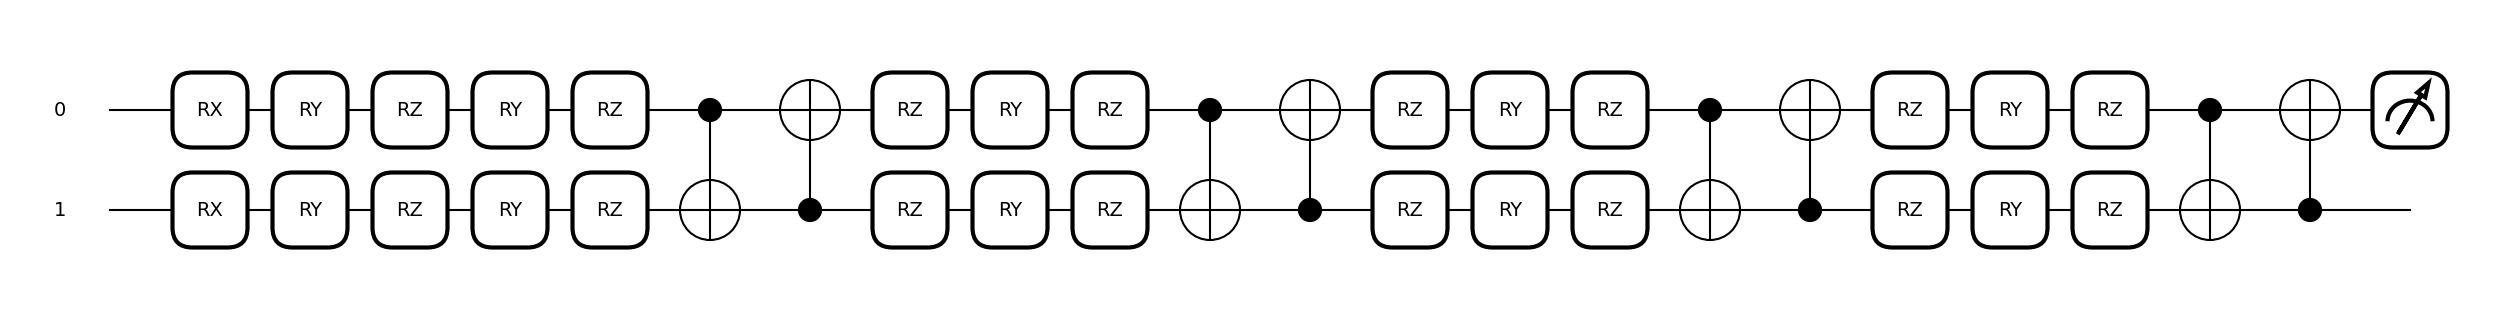

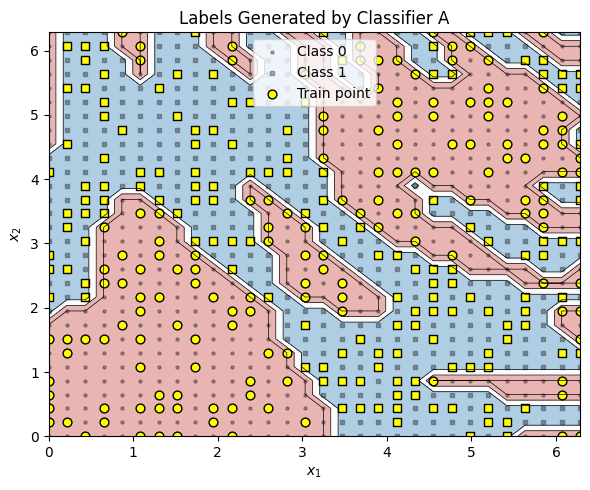

Training B(reupload=original) on data from A(reupload=original)
Total Accuracy: 0.9133333333333333
Train Accuracy: 0.92
Test Accuracy: 0.91
Test Precision: 0.9081632653061225
Test Recall: 0.9081632653061225
Test F1: 0.9081632653061225
Time taken: 261.8424081802368


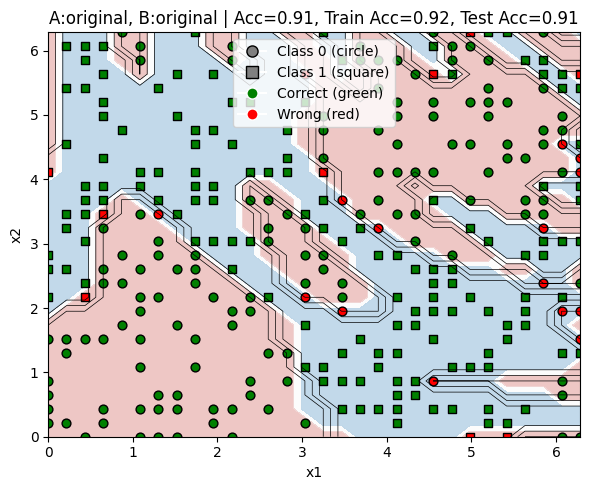

Training B(reupload=rx_only) on data from A(reupload=original)
Total Accuracy: 0.7666666666666667
Train Accuracy: 0.79
Test Accuracy: 0.755
Test Precision: 0.7525773195876289
Test Recall: 0.7448979591836735
Test F1: 0.7487179487179487
Time taken: 217.81661200523376


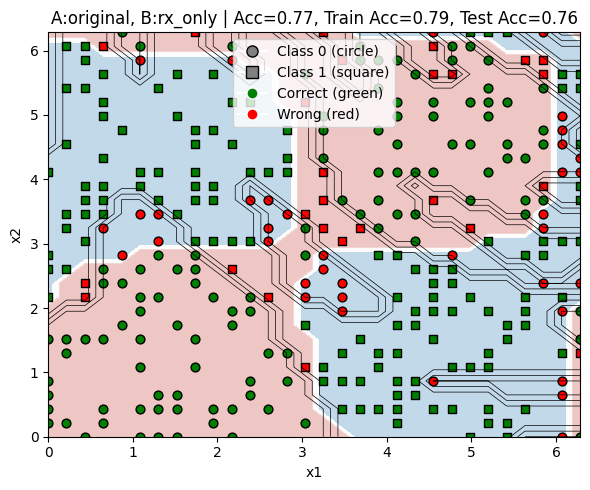

Training B(reupload=chebyshev_sparse) on data from A(reupload=original)
Total Accuracy: 0.5055555555555555
Train Accuracy: 0.54
Test Accuracy: 0.48833333333333334
Test Precision: 0.48
Test Recall: 0.5306122448979592
Test F1: 0.5040387722132471
Time taken: 228.89382147789001


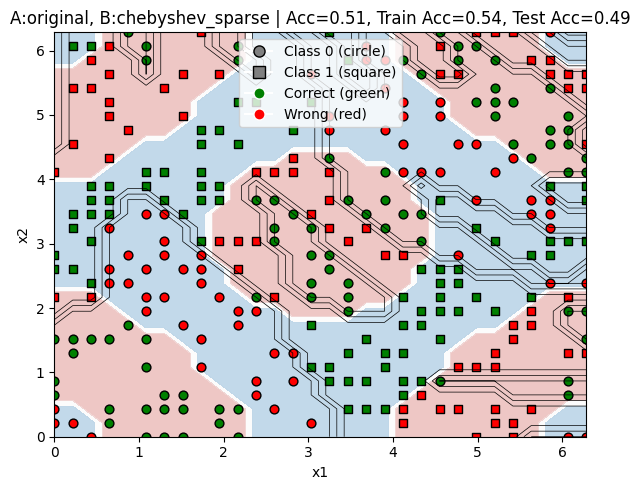

Training B(reupload=chebyshev_tower) on data from A(reupload=original)
Total Accuracy: 0.5188888888888888
Train Accuracy: 0.54
Test Accuracy: 0.5083333333333333
Test Precision: 0.49875311720698257
Test Recall: 0.6802721088435374
Test F1: 0.5755395683453238
Time taken: 298.0621953010559


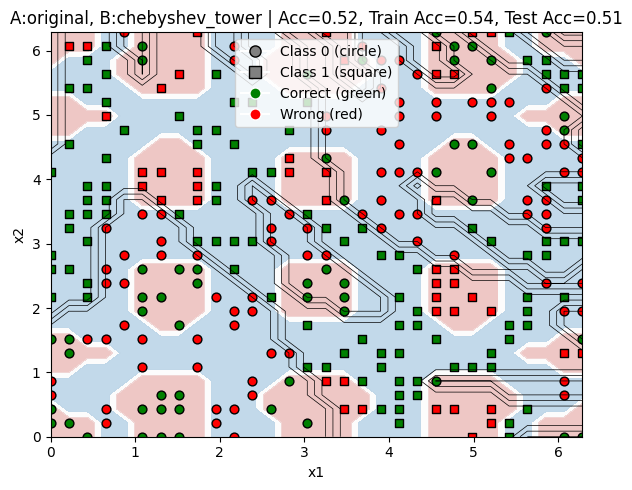

Training B(reupload=fourier) on data from A(reupload=original)
Total Accuracy: 0.5166666666666667
Train Accuracy: 0.57
Test Accuracy: 0.49
Test Precision: 0.4817073170731707
Test Recall: 0.5374149659863946
Test F1: 0.5080385852090032
Time taken: 604.0124413967133


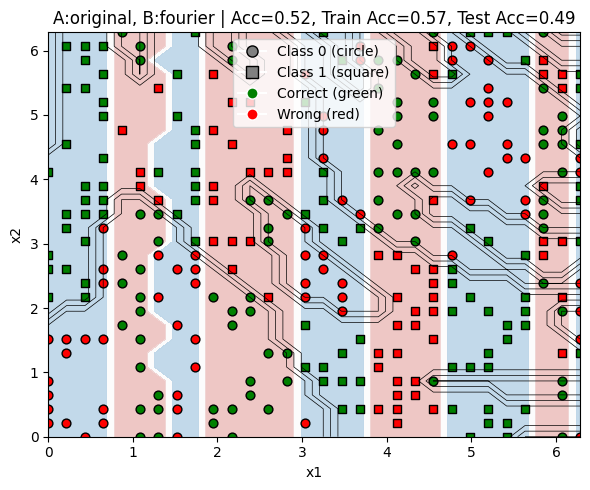

 20%|██        | 1/5 [26:59<1:47:59, 1620.00s/it]

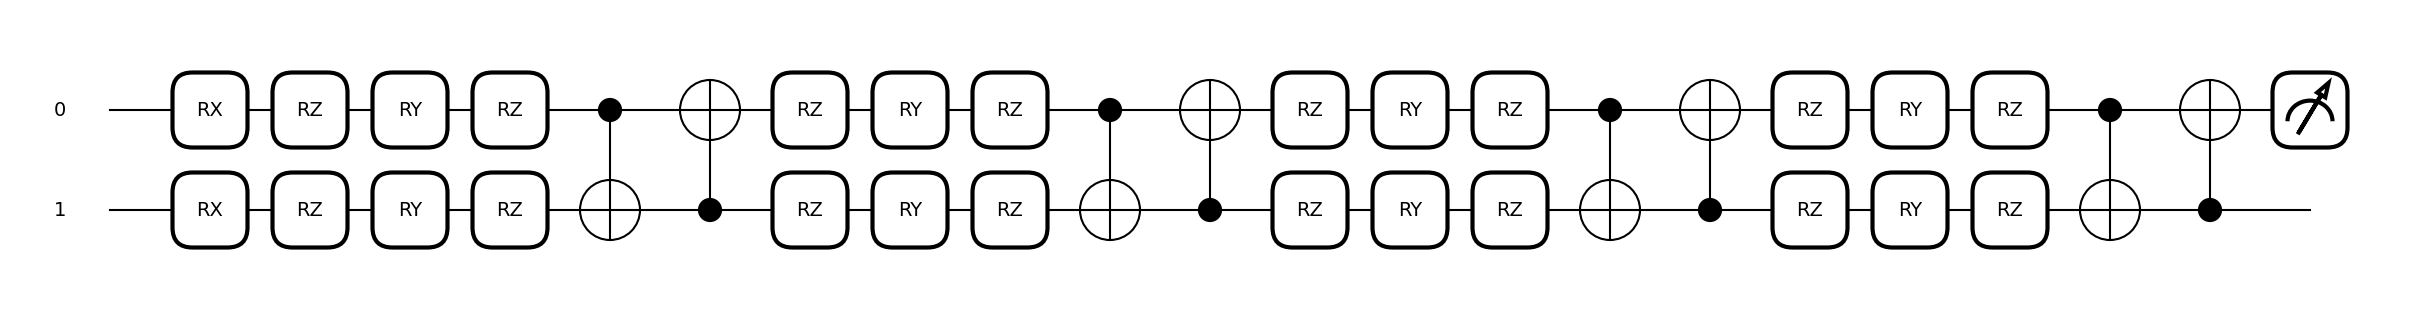

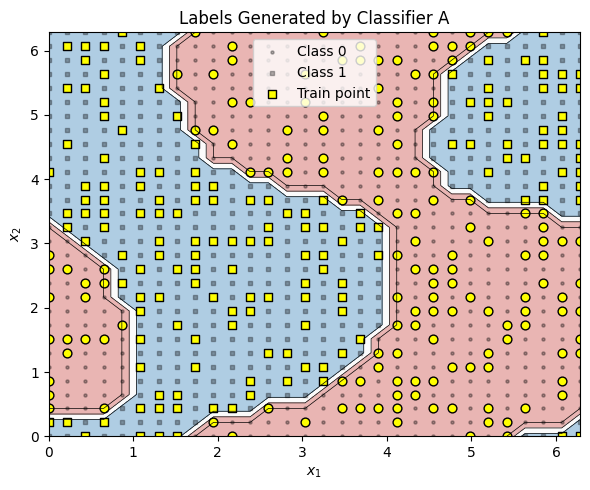

Training B(reupload=original) on data from A(reupload=rx_only)
Total Accuracy: 0.6877777777777778
Train Accuracy: 0.72
Test Accuracy: 0.6716666666666666
Test Precision: 0.6666666666666666
Test Recall: 0.6644067796610169
Test F1: 0.6655348047538199
Time taken: 475.0823757648468


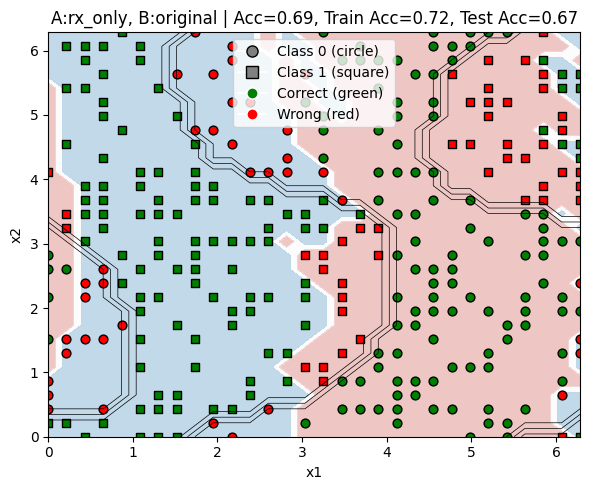

Training B(reupload=rx_only) on data from A(reupload=rx_only)
Total Accuracy: 0.8788888888888889
Train Accuracy: 0.91
Test Accuracy: 0.8633333333333333
Test Precision: 0.8585858585858586
Test Recall: 0.864406779661017
Test F1: 0.8614864864864865
Time taken: 344.62464332580566


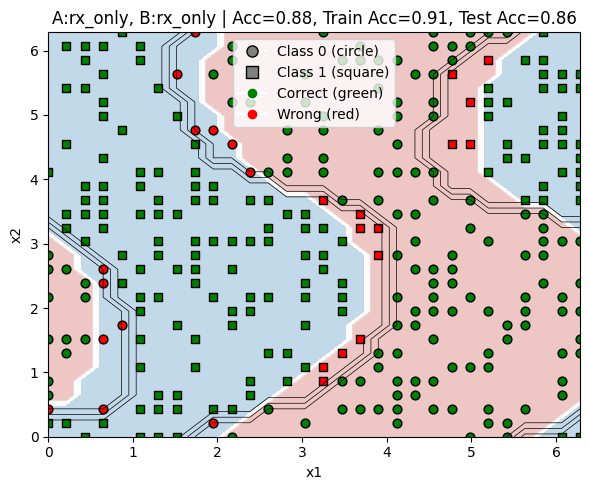

Training B(reupload=chebyshev_sparse) on data from A(reupload=rx_only)
Total Accuracy: 0.5922222222222222
Train Accuracy: 0.6
Test Accuracy: 0.5883333333333334
Test Precision: 0.59375
Test Recall: 0.5152542372881356
Test F1: 0.5517241379310346
Time taken: 217.42116236686707


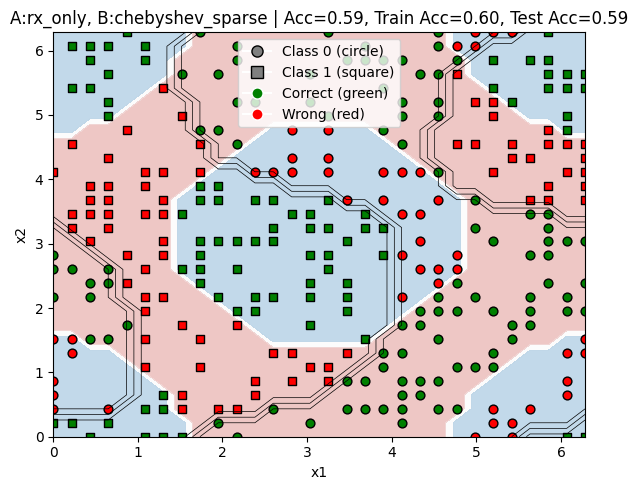

Training B(reupload=chebyshev_tower) on data from A(reupload=rx_only)
Total Accuracy: 0.6055555555555555
Train Accuracy: 0.6233333333333333
Test Accuracy: 0.5966666666666667
Test Precision: 0.5777126099706745
Test Recall: 0.6677966101694915
Test F1: 0.619496855345912
Time taken: 225.3206021785736


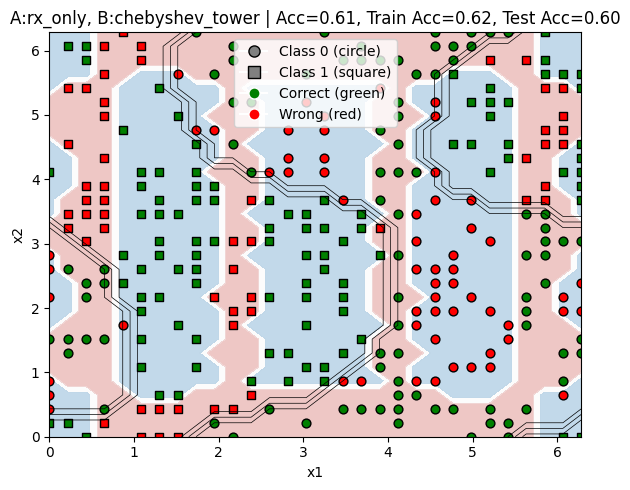

Training B(reupload=fourier) on data from A(reupload=rx_only)
Total Accuracy: 0.6055555555555555
Train Accuracy: 0.58
Test Accuracy: 0.6183333333333333
Test Precision: 0.5891891891891892
Test Recall: 0.7389830508474576
Test F1: 0.6556390977443609
Time taken: 249.11239671707153


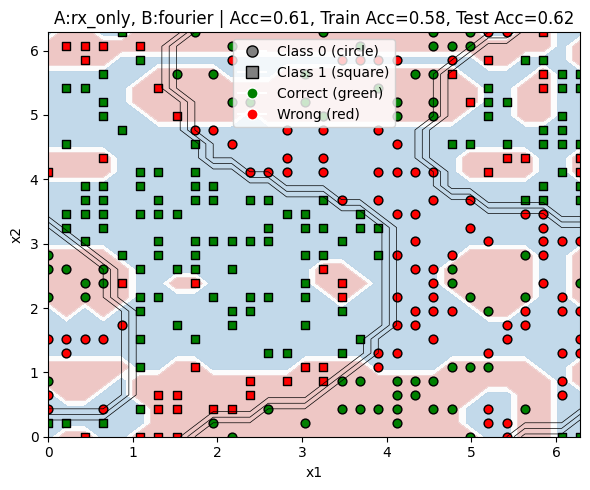

 40%|████      | 2/5 [52:20<1:18:04, 1561.47s/it]

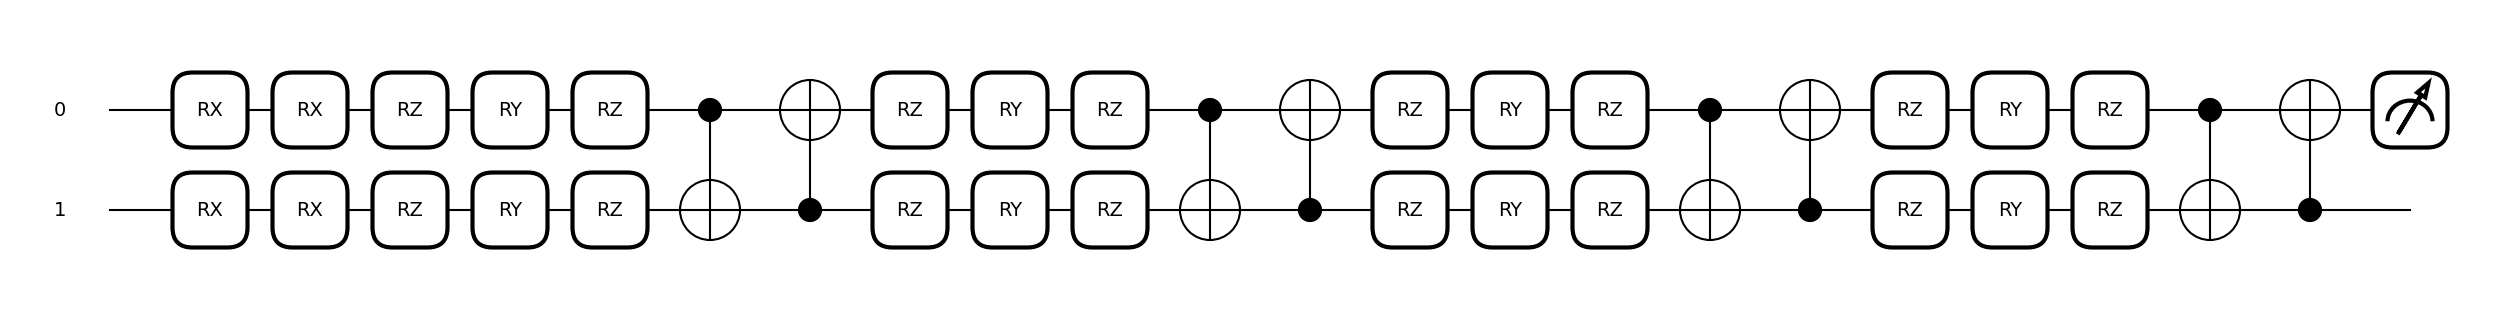

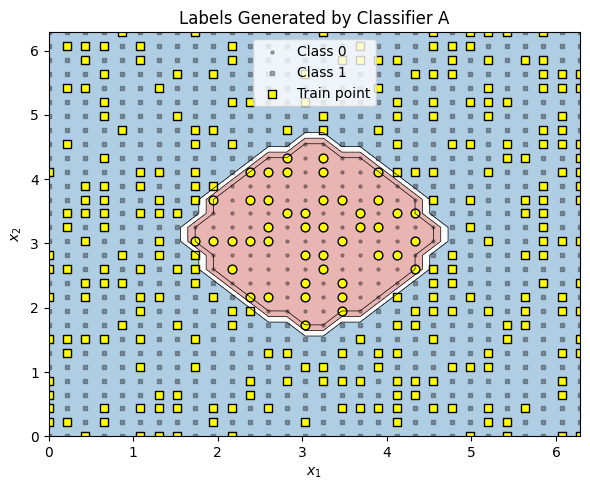

Training B(reupload=original) on data from A(reupload=chebyshev_sparse)
Total Accuracy: 0.6733333333333333
Train Accuracy: 0.6933333333333334
Test Accuracy: 0.6633333333333333
Test Precision: 0.9512893982808023
Test Recall: 0.6421663442940039
Test F1: 0.7667436489607391
Time taken: 216.4434735774994


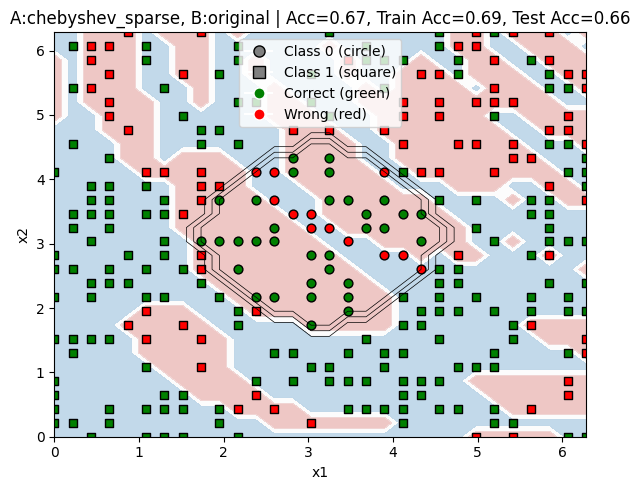

Training B(reupload=rx_only) on data from A(reupload=chebyshev_sparse)
Total Accuracy: 0.6622222222222223
Train Accuracy: 0.7066666666666667
Test Accuracy: 0.64
Test Precision: 1.0
Test Recall: 0.5822050290135397
Test F1: 0.7359413202933985
Time taken: 208.3999891281128


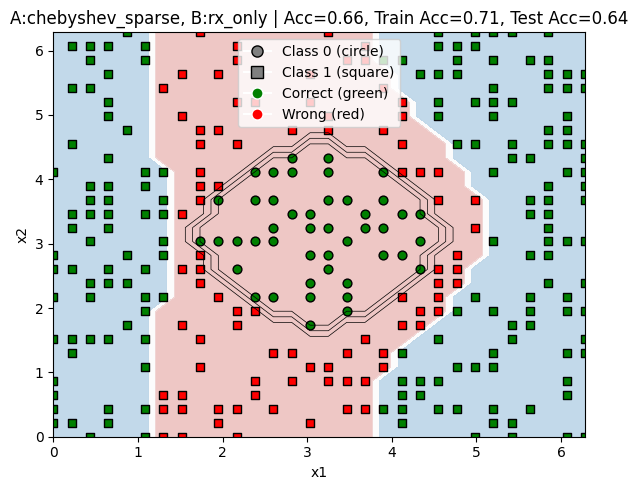

Training B(reupload=chebyshev_sparse) on data from A(reupload=chebyshev_sparse)
Total Accuracy: 0.9822222222222222
Train Accuracy: 0.9866666666666667
Test Accuracy: 0.98
Test Precision: 0.9773156899810964
Test Recall: 1.0
Test F1: 0.988527724665392
Time taken: 218.42827939987183


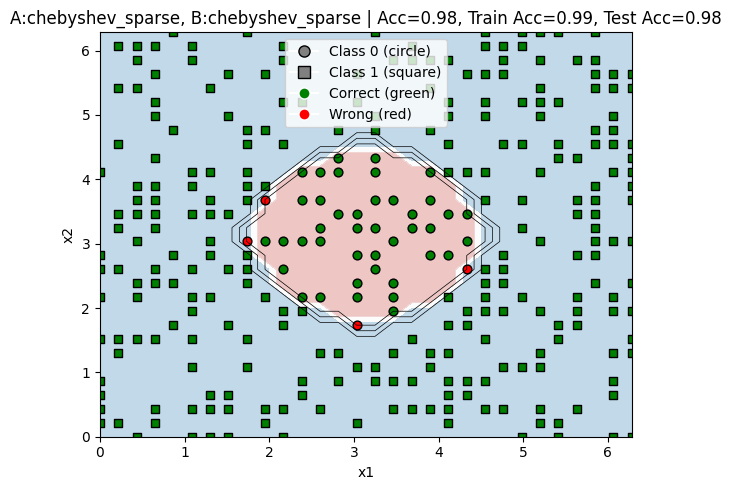

Training B(reupload=chebyshev_tower) on data from A(reupload=chebyshev_sparse)
Total Accuracy: 0.7244444444444444
Train Accuracy: 0.7366666666666667
Test Accuracy: 0.7183333333333334
Test Precision: 0.8385214007782101
Test Recall: 0.8336557059961315
Test F1: 0.8360814742967992
Time taken: 228.23607850074768


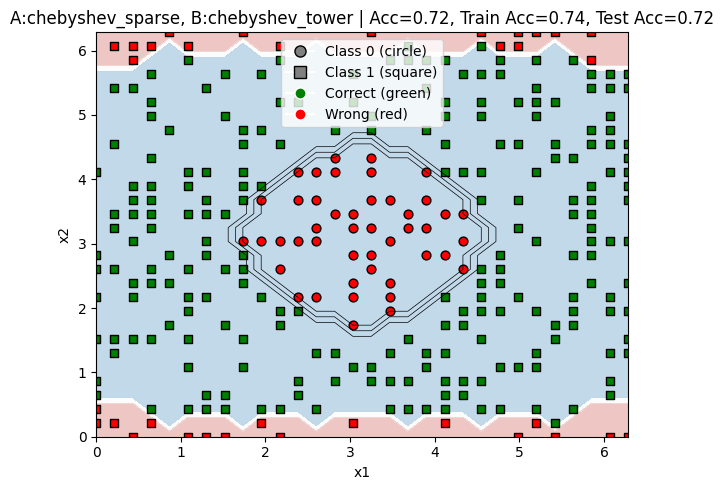

Training B(reupload=fourier) on data from A(reupload=chebyshev_sparse)
Total Accuracy: 0.67
Train Accuracy: 0.67
Test Accuracy: 0.67
Test Precision: 0.8649885583524027
Test Recall: 0.7311411992263056
Test F1: 0.7924528301886792
Time taken: 249.82984232902527


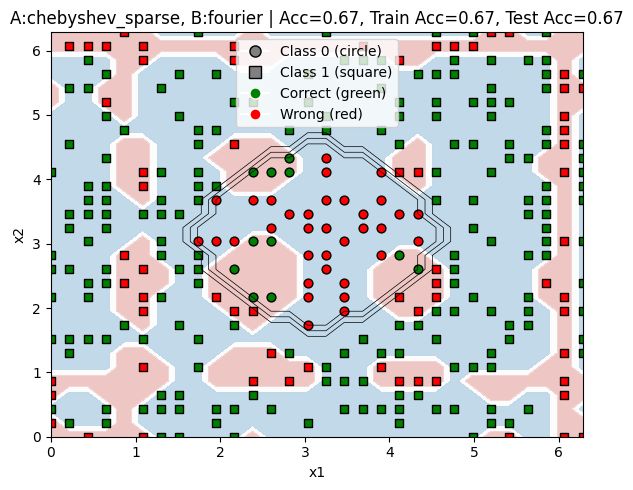

 60%|██████    | 3/5 [1:11:08<45:27, 1363.73s/it]

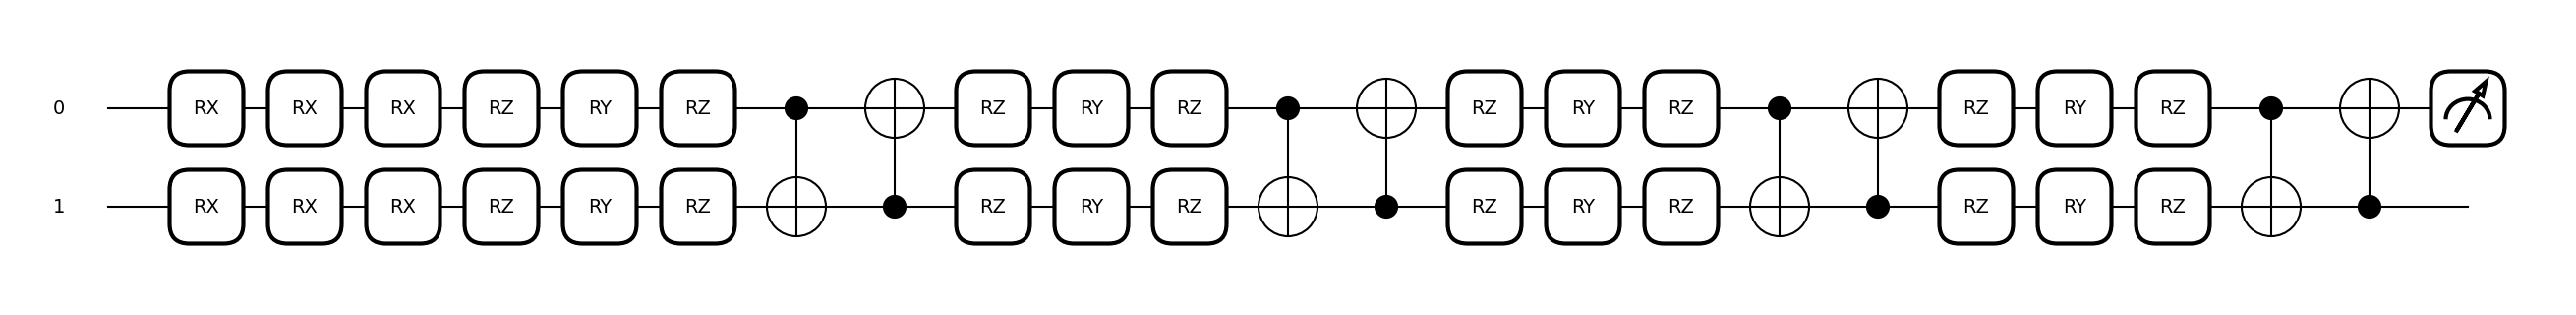

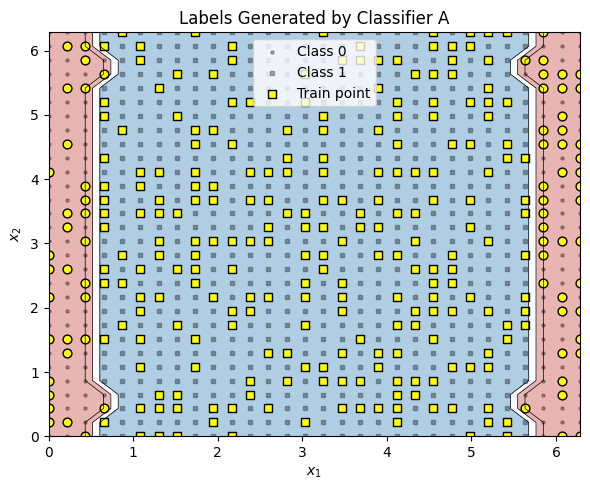

Training B(reupload=original) on data from A(reupload=chebyshev_tower)
Total Accuracy: 0.5622222222222222
Train Accuracy: 0.6066666666666667
Test Accuracy: 0.54
Test Precision: 0.8443708609271523
Test Recall: 0.5268595041322314
Test F1: 0.648854961832061
Time taken: 217.42105221748352


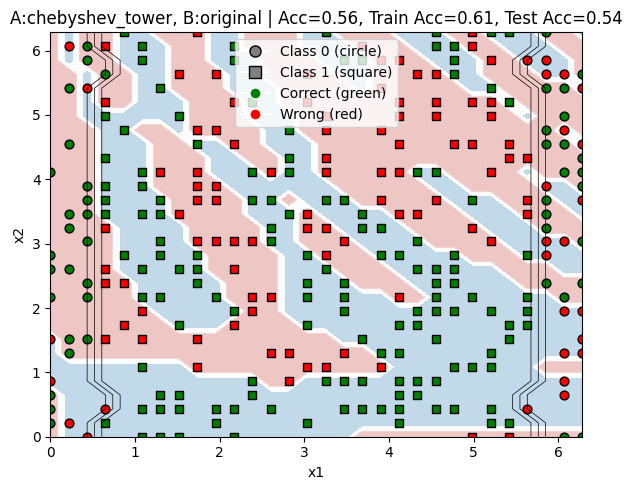

Training B(reupload=rx_only) on data from A(reupload=chebyshev_tower)
Total Accuracy: 0.6922222222222222
Train Accuracy: 0.7066666666666667
Test Accuracy: 0.685
Test Precision: 1.0
Test Recall: 0.609504132231405
Test F1: 0.7573812580231065
Time taken: 210.50671005249023


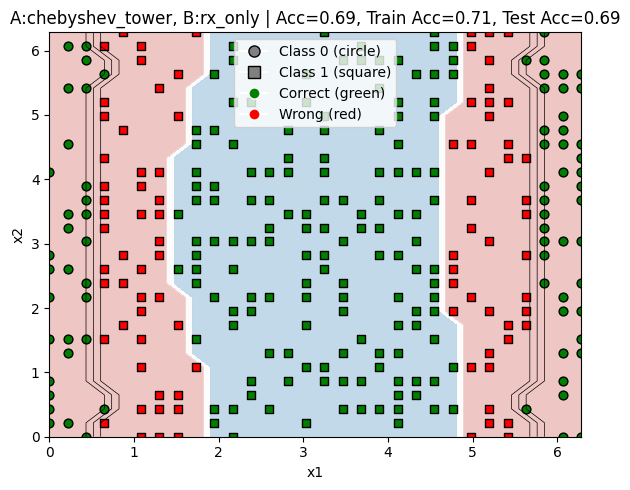

Training B(reupload=chebyshev_sparse) on data from A(reupload=chebyshev_tower)
Total Accuracy: 0.8355555555555556
Train Accuracy: 0.8033333333333333
Test Accuracy: 0.8516666666666667
Test Precision: 0.8790786948176583
Test Recall: 0.9462809917355371
Test F1: 0.9114427860696518
Time taken: 219.13000965118408


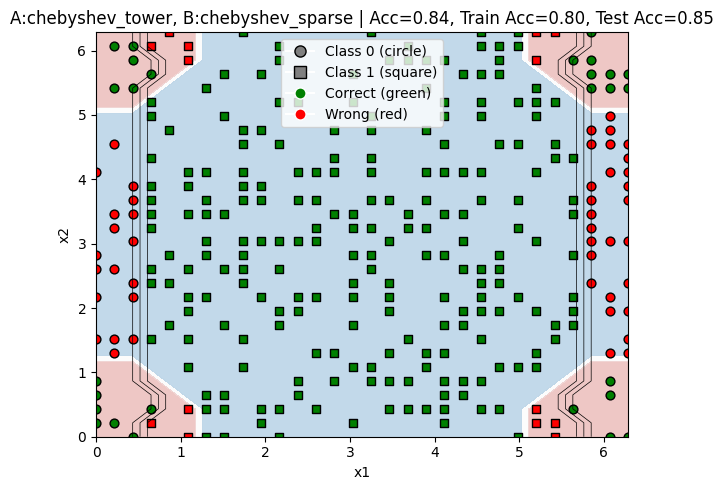

Training B(reupload=chebyshev_tower) on data from A(reupload=chebyshev_tower)
Total Accuracy: 0.9911111111111112
Train Accuracy: 0.9866666666666667
Test Accuracy: 0.9933333333333333
Test Precision: 0.9918032786885246
Test Recall: 1.0
Test F1: 0.9958847736625513
Time taken: 226.64410853385925


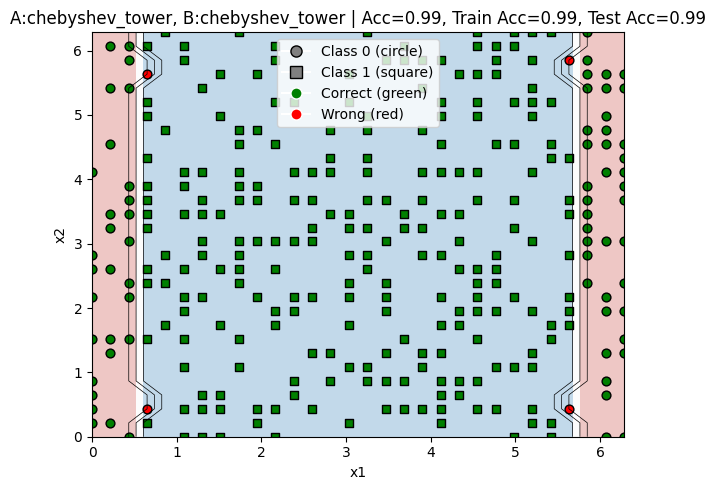

Training B(reupload=fourier) on data from A(reupload=chebyshev_tower)
Total Accuracy: 0.8144444444444444
Train Accuracy: 0.8133333333333334
Test Accuracy: 0.815
Test Precision: 0.9267734553775744
Test Recall: 0.8367768595041323
Test F1: 0.8794788273615635
Time taken: 250.96909022331238


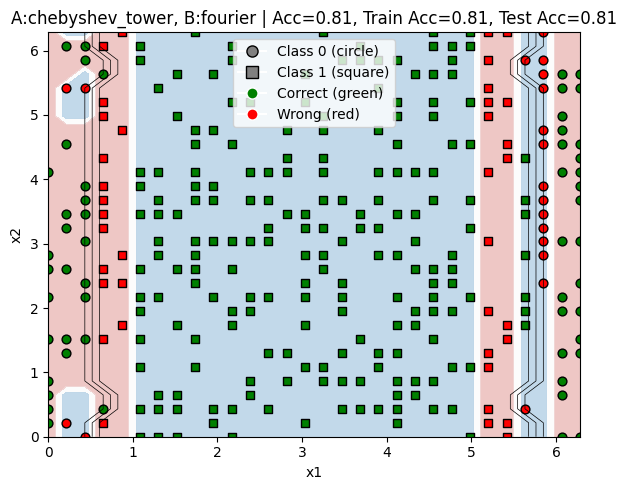

 80%|████████  | 4/5 [1:30:01<21:12, 1272.31s/it]

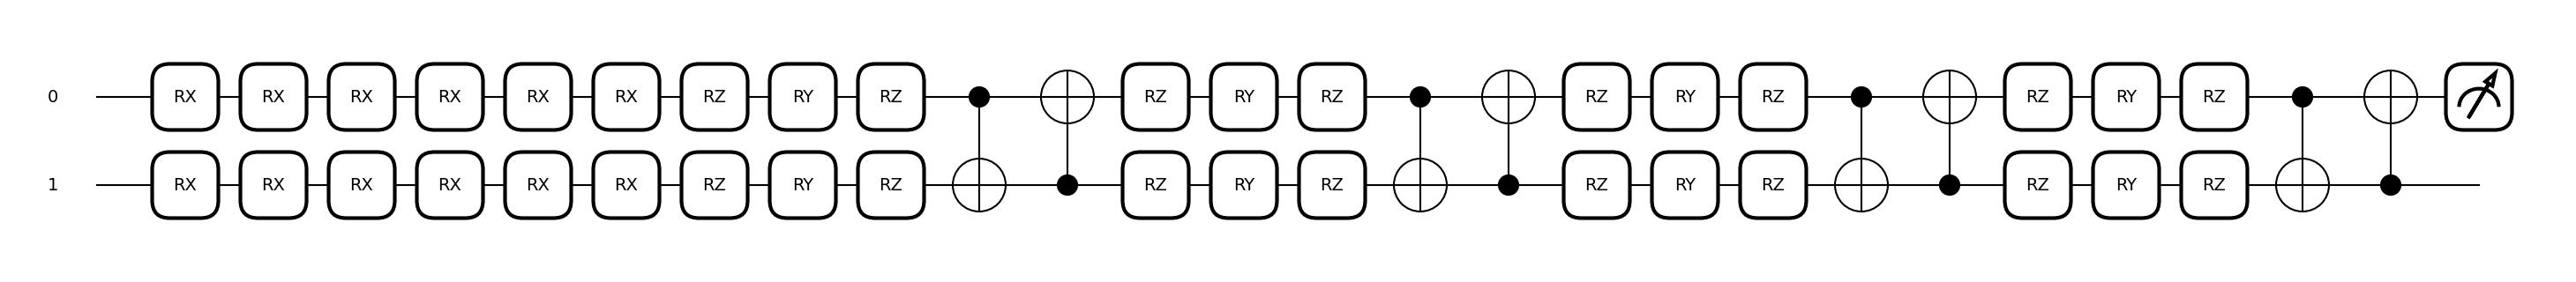

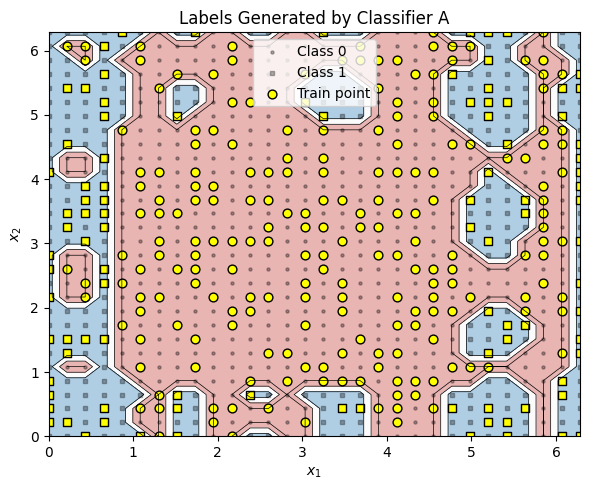

Training B(reupload=original) on data from A(reupload=fourier)
Total Accuracy: 0.56
Train Accuracy: 0.59
Test Accuracy: 0.545
Test Precision: 0.3795379537953795
Test Recall: 0.575
Test F1: 0.45725646123260427
Time taken: 217.67493653297424


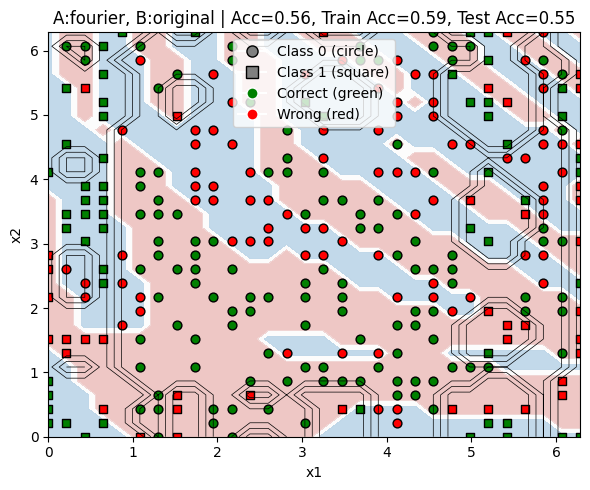

Training B(reupload=rx_only) on data from A(reupload=fourier)
Total Accuracy: 0.7288888888888889
Train Accuracy: 0.7433333333333333
Test Accuracy: 0.7216666666666667
Test Precision: 0.5540983606557377
Test Recall: 0.845
Test F1: 0.6693069306930692
Time taken: 208.88772702217102


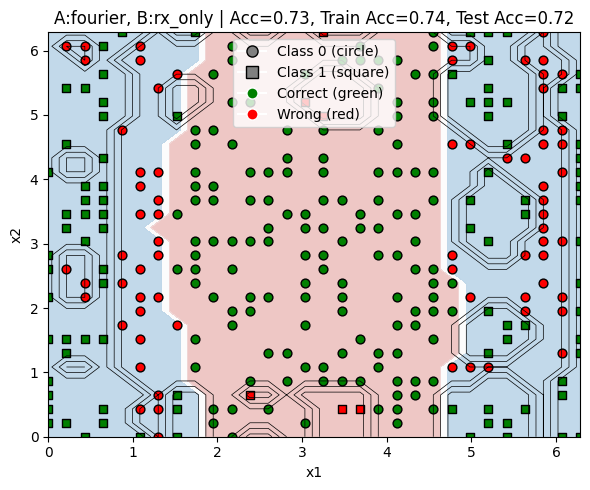

Training B(reupload=chebyshev_sparse) on data from A(reupload=fourier)
Total Accuracy: 0.77
Train Accuracy: 0.7566666666666667
Test Accuracy: 0.7766666666666666
Test Precision: 0.7171052631578947
Test Recall: 0.545
Test F1: 0.6193181818181819
Time taken: 218.4966459274292


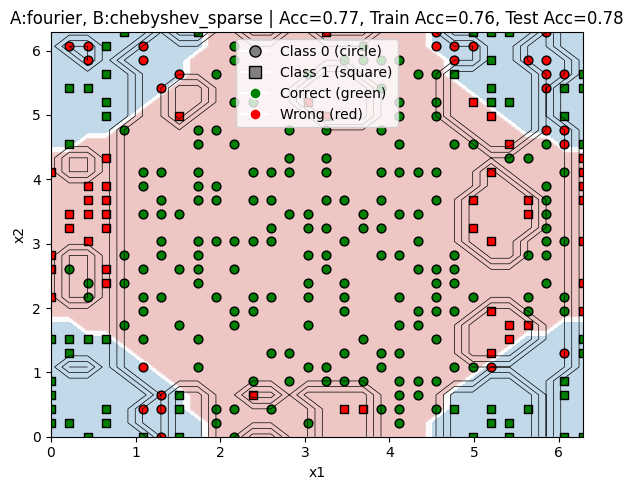

Training B(reupload=chebyshev_tower) on data from A(reupload=fourier)
Total Accuracy: 0.7277777777777777
Train Accuracy: 0.7333333333333333
Test Accuracy: 0.725
Test Precision: 0.6377952755905512
Test Recall: 0.405
Test F1: 0.4954128440366973
Time taken: 227.63946986198425


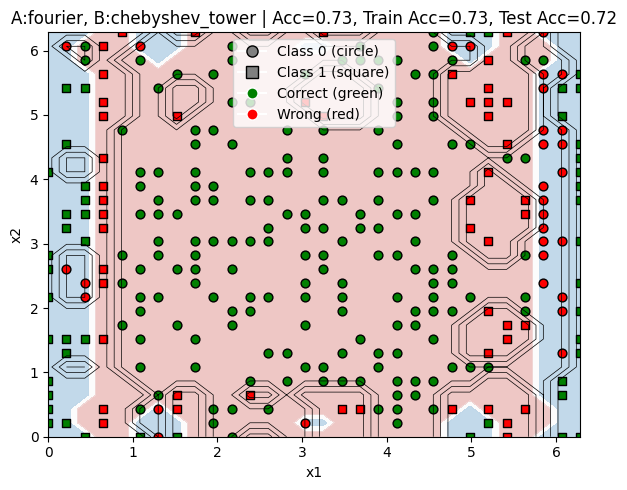

Training B(reupload=fourier) on data from A(reupload=fourier)
Total Accuracy: 0.8533333333333334
Train Accuracy: 0.8933333333333333
Test Accuracy: 0.8333333333333334
Test Precision: 0.7525252525252525
Test Recall: 0.745
Test F1: 0.7487437185929648
Time taken: 249.30811595916748


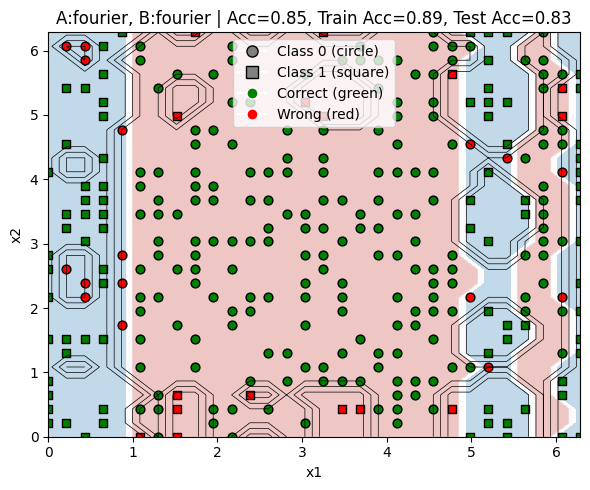

100%|██████████| 5/5 [1:48:52<00:00, 1306.57s/it]


In [ ]:

for name_A,depth_A in tqdm(depths.items()):
    # Generate labels using fixed A
    devA = qml.device("default.qubit", wires=n_qubits)
    weights_A = np.random.uniform(0, 2*np.pi, size=(4, n_qubits, 3))
    circuit_A = create_qnode(4, weights_A, devA, 1, depth_A)
    labels_A = generate_labels(circuit_A, inputs)
    y_train = torch.tensor(labels_A[train_idx], dtype=torch.float32).unsqueeze(1)
    y_test = torch.tensor(labels_A[test_idx], dtype=torch.float32).unsqueeze(1)
    qml.drawer.draw_mpl(circuit_A)([0, 1]);
    
    plot_generator_A(labels_A, "Labels Generated by Classifier A", X=inputs, train_idx=train_idx)
    for name_B,depth_B in tqdm(depths.items()):
        print(f"Training B(reupload={name_B}) on data from A(reupload={name_A})")
        devB = qml.device("default.qubit", wires=n_qubits)
        model_B = get_torch_model(4, devB, 1,depth_B)
        start_time = time.time()
        trained_model = train_model(model_B, X_train, y_train)

        # Evaluate model
        with torch.no_grad():
            preds = torch.stack([trained_model(x) for x in torch.tensor(inputs, dtype=torch.float32)]).numpy().flatten()
            pred_labels = (preds > 0).astype(int)
            
        train_preds = pred_labels[train_idx]
        test_preds = pred_labels[test_idx]

        acc = accuracy_score(labels_A, pred_labels)
        
        train_acc = accuracy_score(labels_A[train_idx], train_preds)
        test_acc = accuracy_score(labels_A[test_idx], test_preds)
        precision = precision_score(labels_A[test_idx], test_preds)
        recall = recall_score(labels_A[test_idx], test_preds)
        f1 = f1_score(labels_A[test_idx], test_preds)
        # Plot
        title = f"A:{name_A}, B:{name_B} | Acc={acc:.2f}, Train Acc={train_acc:.2f}, Test Acc={test_acc:.2f}"
        print("Total Accuracy:", acc)
        print("Train Accuracy:", train_acc)
        print("Test Accuracy:", test_acc)
        print("Test Precision:", precision)
        print("Test Recall:", recall)
        print("Test F1:", f1)
        print("Time taken:", time.time() - start_time)
        plot_results(labels_A, pred_labels, title, inputs, train_idx)
        
        results.append((name_A, name_B, acc, train_acc, test_acc))




In [19]:
def get_key_by_value(d, val):
    for k, v in d.items():
        if v is val:
            return k
    return None


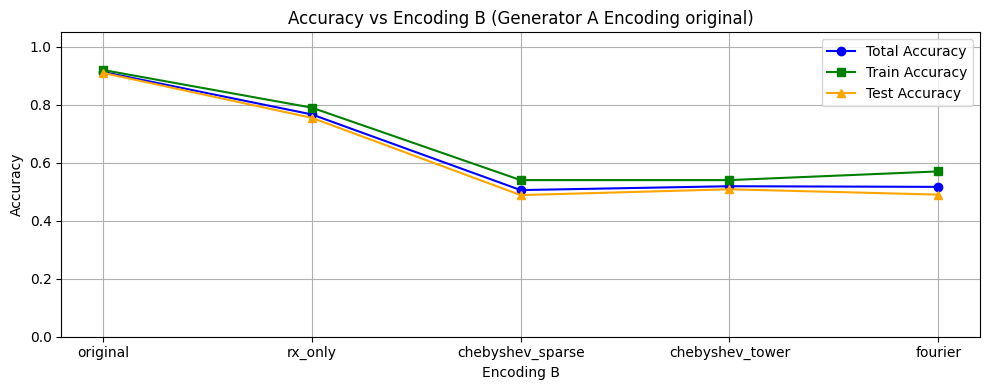

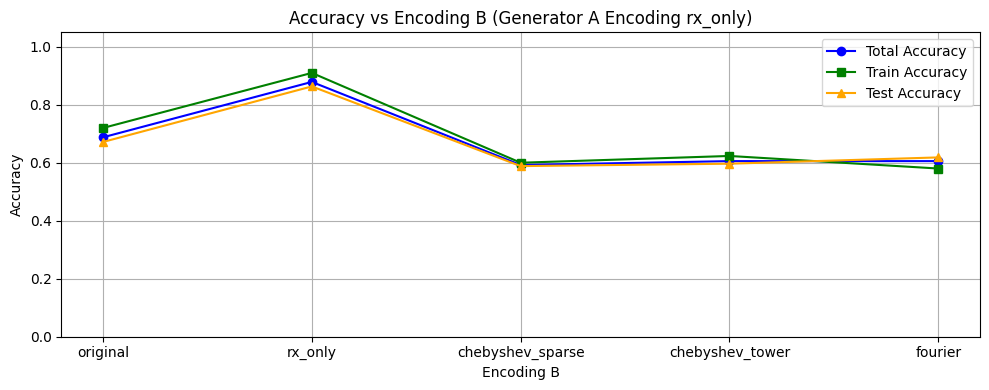

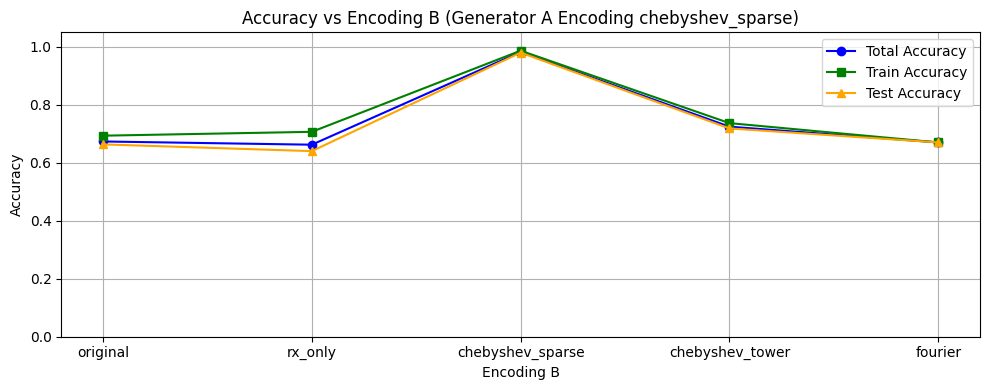

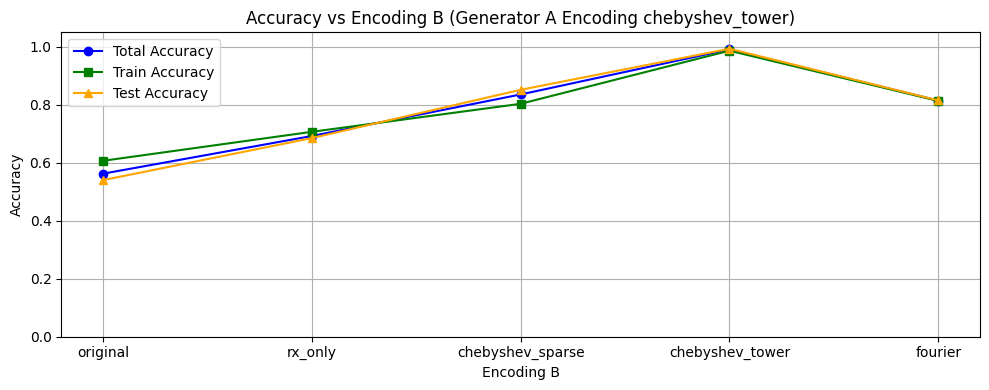

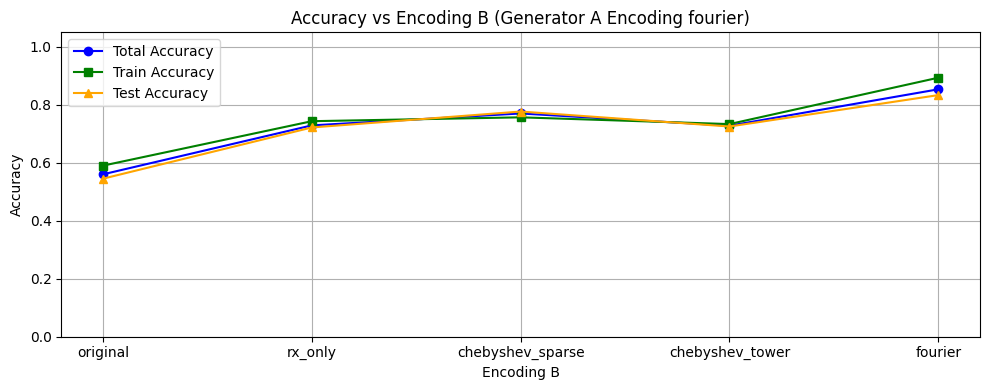

In [22]:

# Updated DataFrame with new 
results2 = []
count = 0
for depth_A,depth_B, acc,train_acc,test_acc in results:
    if count>=25:
        break
    key_A = get_key_by_value(depths,depth_A)
    key_B = get_key_by_value(depths,depth_B)
    results2.append((key_A,key_B,acc,train_acc,test_acc))
    count+=1
df_results = pd.DataFrame(results2, columns=["depth_A", "depth_B", "total_acc", "train_acc", "test_acc"])

# Plot for each depth_A
for depth_A in df_results["depth_A"].unique():
    subset = df_results[df_results["depth_A"] == depth_A]

    plt.figure(figsize=(10, 4))

    # Accuracy plot
    plt.plot(subset["depth_B"], subset["total_acc"], marker='o', label="Total Accuracy", color='blue')
    plt.plot(subset["depth_B"], subset["train_acc"], marker='s', label="Train Accuracy", color='green')
    plt.plot(subset["depth_B"], subset["test_acc"], marker='^', label="Test Accuracy", color='orange')

    plt.title(f"Accuracy vs Encoding B (Generator A Encoding {depth_A})")
    plt.xlabel("Encoding B")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1.05)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [21]:
print("done")

done
